In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [15]:
data = pd.read_csv('AAPL.csv')


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10763 entries, 0 to 10762
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10763 non-null  object 
 1   Open       10763 non-null  float64
 2   High       10763 non-null  float64
 3   Low        10763 non-null  float64
 4   Close      10763 non-null  float64
 5   Adj Close  10763 non-null  float64
 6   Volume     10763 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 588.7+ KB


In [17]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10763 entries, 0 to 10762
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10763 non-null  datetime64[ns]
 1   Open       10763 non-null  float64       
 2   High       10763 non-null  float64       
 3   Low        10763 non-null  float64       
 4   Close      10763 non-null  float64       
 5   Adj Close  10763 non-null  float64       
 6   Volume     10763 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 588.7 KB


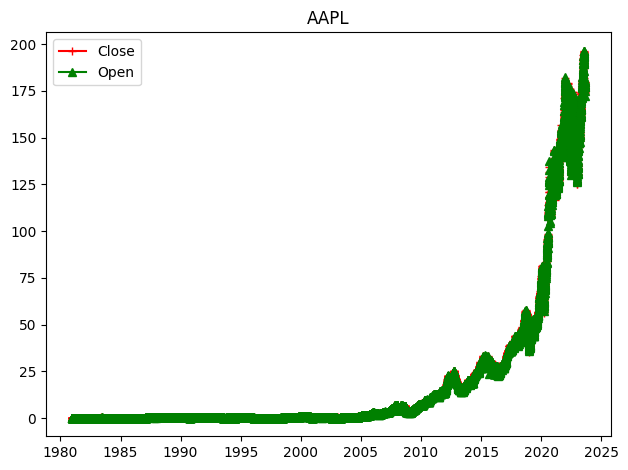

In [18]:
plt.plot(data['Date'], data['Close'], c="r", label="Close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="Open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()
plt.show()  

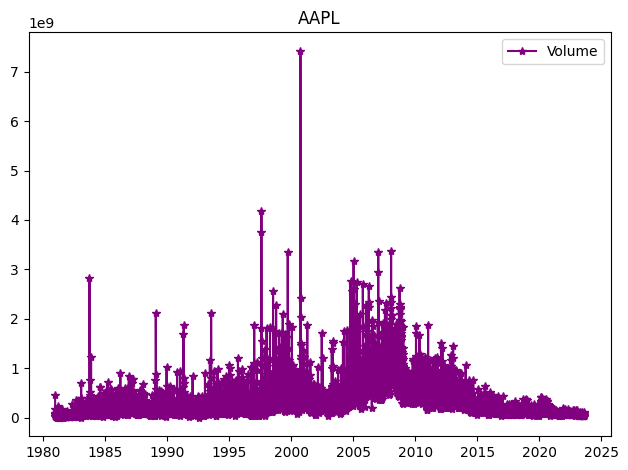

In [19]:
plt.plot(data['Date'], data['Volume'], c='purple', marker='*', label='Volume')
plt.title("AAPL")
plt.legend()
plt.tight_layout()
plt.show()  

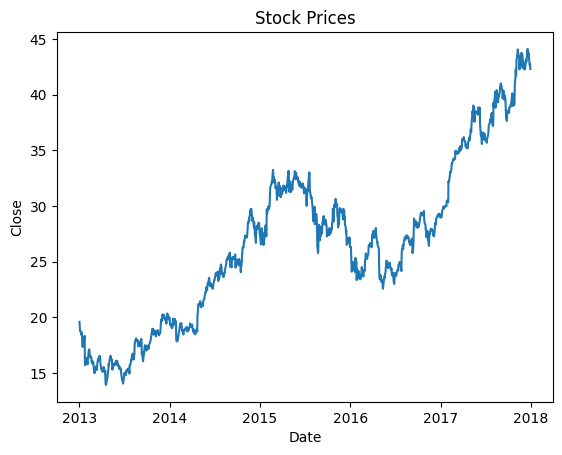

In [20]:

stock_data = data.copy()

# Date filter
prediction_range = stock_data.loc[(stock_data['Date'] > datetime(2013,1,1))
                                 & (stock_data['Date']<datetime(2018,1,1))]

# Plotting
plt.plot(prediction_range['Date'], prediction_range['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Stock Prices")  # Keeping the title generic since we're not filtering by ticker
plt.show()


In [21]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)
print(close_data.shape)
print(dataset.shape)

10225
(10763, 1)
(10763, 1)


In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [23]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('loss') < 0.4):

      # Stop if threshold is met
      print("\nLoss is lower than 0.4 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=10, callbacks=[callbacks])



Epoch 1/10
318/318 [==============================] - ETA: 0s - loss: 0.0012
Loss is lower than 0.4 so cancelling training!
318/318 [==============================] - 9s 23ms/step - loss: 0.0012


In [25]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

17/17 [==============================] - 0s 6ms/step
MSE 163.51778726142928
RMSE 12.787407370590383


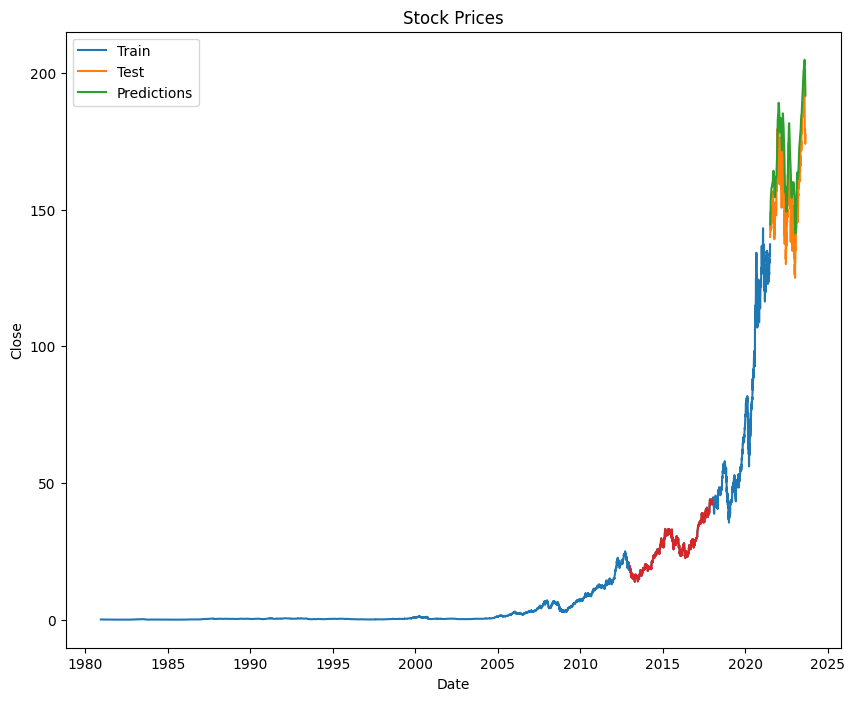

In [27]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('AAPL Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])


stock_data = data.copy()

# Date filter
prediction_range = stock_data.loc[(stock_data['Date'] > datetime(2013,1,1))
                                 & (stock_data['Date']<datetime(2018,1,1))]

# Plotting
plt.plot(prediction_range['Date'], prediction_range['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Stock Prices")  # Keeping the title generic since we're not filtering by ticker
plt.show()
